# Final Report and Summary of Analysis: Improving Timely Diagnoses in Medical Imaging

#### CONTENTS

    I. Purpose
    II. Data and Context
    III. Model Creation
    IV. Evaluate Results
    V. Recommendations
    VI. Next Steps

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

import tensorflow as tf
print(tf.__version__)

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.functions as fn

plt.style.use('fivethirtyeight')

2.2.0


## I. Purpose

Applications of technology in the field of medicine have come in many forms, including equipment and procedural advancements. With the goal of improving the quality of health and care that is delivered to patients, the purpose of this notebook is to explore the use of Neural Networks in medical imaging to aid in the timely diagnoses to those who need it most. 

#### Goal:

Build a tool that uses a Convolutional Neural Network (CNN) to assist in diagnosing patients with Pneumonia. This Neural Network will reliably identify patients with pneumonia so radiologists and doctors can prioritize those patients for quicker review, diagnoses, and treatment.

## II. Data and Context

Our data comes from Guangzhou Women and Children’s Medical Center. The original data set can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
- Reviewed by two physicians to confirm the accuracy of the diagnoses. 
- Includes bacterial and viral pneumonia.
- Uses anterior and posterior ex-ray views.

### Data Cleaning

While exploring the image data set, we discovered that a number of images in the pneumonia data set had visible medical equipment, while very few of the healthy lung images had such medical equipment. 

Here is a pneumonic lung x-ray with what appears to be an IV in the upper right corner of the image, and an electrode on the upper left, along with some type of tubing to the left of the heart and across the lower ribcage.

<img src="../../references/person109_bacteria_519.jpeg" alt="drawing" width="400"/> 

Here is another x-ray of a pneumonic lung, this time with no visible medical euipment. We would consider this a clean image.

<img src="../../references/person3_virus_15.jpeg" alt="drawing" width="400"/>

#### Why does this matter?
We want to make sure that our model is examining lungs for signs of pneumonia in a similar manner to an actual physician or radiologist. With this medical equipment being so prevelant in the pneumonic lung images, we may inadvertantly train our model to interpret medical equipment as a sign of pneuomonia.

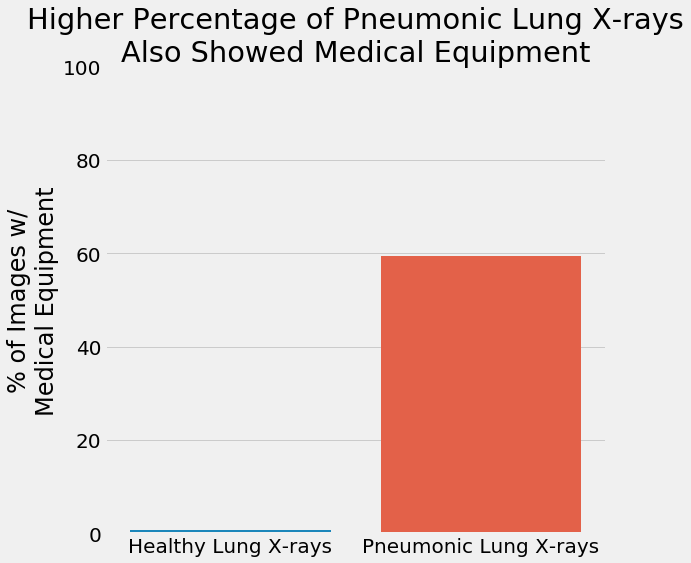

In [11]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(8,8))
labels = 'Clean X-rays', 'X-rays with Visible\nMedical Equipment'
healthy = 9/(1132+9)*100
ill = 2105/(1436+2105)*100
explode = (0, 0.01)

sns.barplot(['Healthy Lung X-rays', 'Pneumonic Lung X-rays'], [healthy, ill])
ax.set_ylim(0,100)
ax.set_ylabel('% of Images w/\nMedical Equipment')
ax.set_title('Higher Percentage of Pneumonic Lung X-rays\nAlso Showed Medical Equipment');

#### Solution:
We went through each image in the training data and manually deleted all x-rays that appeared to have medical equipment in them. This cut out about 1500 images unfortunately, but we determined this was worth it in order to prevent a model from learning incorrectly.

## III. Model Creation

#### Summary of Workflow

    1. Build First Simple Model
     - Evaluate
    2. Build additional models using a variety of methods and architechtures
     - Optimize for Recall and Accuracy
     - Review results and explore new approaches for feature engineering
     - Repeat steps 3 and 4
     - Choose the best model 

### 1. Build First Simple Model

In [2]:
train_data, val_data, test_data = fn.load_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Parameters:
- Layers:
 - Flatten layer
   - Note on input shape: The data generators for this model provided images that were greyscale at dimensions 100x100
 - Dense layer with 85 nodes and ReLU activation
 - Output layer
- Optimizer: Adam
- Loss: binary crossentropy

In [3]:
model = Sequential()
model.add(Flatten(input_shape=(100,100,1)))
model.add(Dense(units=85, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

### Fit model
#### This cell may take more than 10 minutes to run
- Trained for 10 epochs
- Number of steps is set equal to the length of the data generator which means it will run through every image at each epoch.

In [4]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=(val_data), 
                    steps_per_epoch=len(train_data), 
                    validation_steps=len(val_data))

Epoch 1/10
81/81 [==============================] - 54s 662ms/step - loss: 0.9850 - accuracy: 0.6351 - precision: 0.6430 - recall: 0.7813 - val_loss: 0.5532 - val_accuracy: 0.7873 - val_precision: 0.7922 - val_recall: 0.8918
Epoch 2/10
81/81 [==============================] - 51s 625ms/step - loss: 0.5194 - accuracy: 0.7640 - precision: 0.7470 - recall: 0.8740 - val_loss: 0.4885 - val_accuracy: 0.8091 - val_precision: 0.8937 - val_recall: 0.7865
Epoch 3/10
81/81 [==============================] - 48s 596ms/step - loss: 0.4450 - accuracy: 0.8053 - precision: 0.7951 - recall: 0.8781 - val_loss: 0.4188 - val_accuracy: 0.8364 - val_precision: 0.8795 - val_recall: 0.8538
Epoch 4/10
81/81 [==============================] - 45s 552ms/step - loss: 0.4062 - accuracy: 0.8220 - precision: 0.8266 - recall: 0.8628 - val_loss: 0.3583 - val_accuracy: 0.8527 - val_precision: 0.8896 - val_recall: 0.8713
Epoch 5/10
81/81 [==============================] - 44s 548ms/step - loss: 0.3967 - accuracy: 0.8252

## Evaluation on holdout

In [5]:
acc = model.evaluate(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 5s 266ms/step - loss: 0.3890 - accuracy: 0.8157 - precision: 0.8022 - recall: 0.9359


[('loss', 0.3890226185321808),
 ('accuracy', 0.8157051205635071),
 ('precision', 0.8021978139877319),
 ('recall', 0.9358974099159241)]

### 2. Building Additional Models 

## IV. Final Results

## V. Recommendations

## VI. Next Steps